# Esercizio 6: Modello di Ising 1d - Metodi Monte Carlo

Di seguito sono riportate delle simulazioni del modello di Ising 1d nell'ensemble canonico. La distribuzione di Boltzmann è campionata con algoritmo di Metropolis e di Gibbs. Per l'algoritmo di Metropolis, la probabilità di transizione $T(y|x)$ è uniforme sulle configurazioni $y$ che differiscono da $x$ per lo switch di uno spin.

Il sistema è simulato con i seguenti parametri:
- 50 spin in pbc
- T = 2.0
- J = 1.0
- h = 0 (tranne per il grafico della magnetizzazione, dove vale 0.02)

In [2]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import math
from scipy import log, exp, sqrt

def block_ave(data, blocks): #returns array of length "blocks"
    if blocks <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    ave = np.zeros(blocks)
    block_size = int(data.size/blocks)
    for i in range(blocks):
        block_sum = 0
        for j in range(block_size):
            k = j+i*block_size
            block_sum += data[k]
            ave[i] = block_sum/block_size  
    return ave

def error(ave,ave2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((ave2 - ave**2)/n)
    
def prog_ave(vec):
    prog_ave = np.zeros(vec.size)
    prog_ave2 = np.zeros(vec.size)
    vec2 = np.zeros(vec.size)
    err_prog = np.zeros(vec.size)
    for i in range(vec.size):
        vec2[i]= vec[i]**2
        for j in range(i+1):
            prog_ave[i] += vec[j]
            prog_ave2[i] += vec2[j]
        prog_ave[i] = prog_ave[i]/(i+1)
        prog_ave2[i] = prog_ave2[i]/(i+1)
        err_prog[i] = error(prog_ave[i], prog_ave2[i], i)
    return prog_ave, err_prog

def data_blocking(data, block_size):
    if block_size <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    
    blocks = int(data.size/block_size)
    error = np.zeros(blocks)
    cumul_ave = np.zeros(blocks)
    block_ave = 0
    m_sum = 0
    m_sum2 = 0
    
    for i in range(blocks):
        block_sum = 0
        for j in range(block_size):
            block_sum += data[j+i*block_size]
        block_ave  = block_sum/block_size 
        m_sum += block_ave
        m_sum2 += block_ave**2
        cumul_ave[i] = m_sum/(i+1)
        if i==0:
            error[i]=0
        else:
            error[i] = math.sqrt( (m_sum2/(i+1) - (m_sum/(i+1))**2)/i )
    return cumul_ave, error

Studiamo l'andamento dell'energia interna e della magnetizzazione nei primi step Monte Carlo. Il sistema è pressochè immediatamente equilibrato. Più la temperatura è alta, più la distribuzione di Boltzmann desiderata è vicina alla distribuzione uniforme con cui viene generata la configurazione di partenza e quindi il tempo di equilibrazione è piccolo.

I parametri nel modello sono considerati adimensionali quindi lo saranno anche le osservabili magnetizzazione e energia

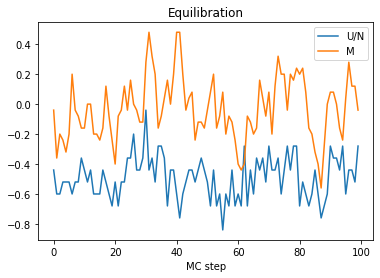

In [13]:
u, m = np.loadtxt('equilibration.dat', unpack=True)
blocks = 100
plt.plot(u, label='U/N')
plt.plot(m, label='M')
plt.title('Equilibration')
plt.xlabel('MC step')
plt.legend()
plt.show()

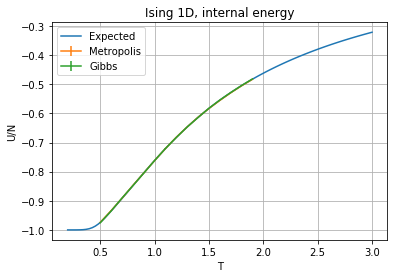

In [15]:
points=100
T = np.linspace(0.2,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

plt.plot(T, e, label='Expected')
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')

data_u = np.loadtxt('simul/output.ene.m')
t_u = data_u[:,0]
u = data_u[:,1]
err_u = data_u[:,2]
plt.errorbar(t_u, u, err_u, label='Metropolis')

data_u_g = np.loadtxt('simul/output.ene.g')
t_u_g = data_u_g[:,0]
u_g = data_u_g[:,1]
err_u_g = data_u_g[:,2]
plt.errorbar(t_u_g, u_g, err_u_g, label='Gibbs')

plt.legend()
plt.grid()
plt.show()

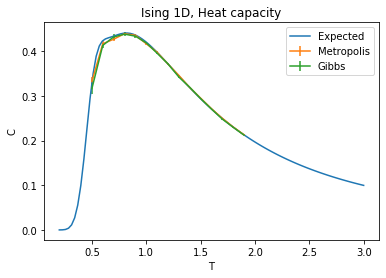

In [16]:
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label='Expected')
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')

data_c = np.loadtxt('simul/output.heat.m')
t_c = data_c[:,0]
c = data_c[:,1]
err_c = data_c[:,2]
plt.errorbar(t_c, c, err_c, label='Metropolis')

data_c_g = np.loadtxt('simul/output.heat.g')
t_c_g = data_c_g[:,0]
c_g = data_c_g[:,1]
err_c_g = data_c_g[:,2]
plt.errorbar(t_c_g, c_g, err_c_g, label='Gibbs')
plt.grid(True)

plt.legend()
plt.grid()
plt.show()

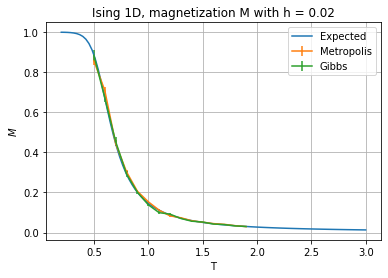

In [17]:
h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T, M, label='Expected')
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')

data_m = np.loadtxt('simul/output.mag.m')
t_m = data_m[:,0]
m = data_m[:,1]
err_m = data_m[:,2]
plt.errorbar(t_m, m, err_m, label='Metropolis')

data_m_g = np.loadtxt('simul/output.mag.g')
t_m_g = data_m_g[:,0]
m_g = data_m_g[:,1]
err_m_g = data_m_g[:,2]
plt.errorbar(t_m_g, m_g, err_m_g, label='Gibbs')

plt.legend()
plt.grid()
plt.show()

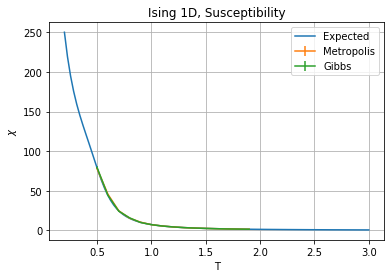

In [18]:
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T, X, label='Expected')
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel('$\chi$')

data_x = np.loadtxt('simul/output.chi.m')
t_x = data_x[:,0]
x = data_x[:,1]
err_x = data_x[:,2]
plt.errorbar(t_x, x, err_x, label='Metropolis')

data_x_g = np.loadtxt('simul/output.chi.g')
t_x_g = data_x_g[:,0]
x_g = data_x_g[:,1]
err_x_g = data_x_g[:,2]
plt.errorbar(t_x_g, x_g, err_x_g, label='Gibbs')
plt.legend()
plt.grid()
plt.show()